In [ ]:
import pickle
pickle_in1=open('/content/drive/My Drive/result_final.pickle','rb')
result_df=pickle.load(pickle_in1)

In [ ]:
result_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.652050,-0.007411,0.368659,0.128340,-0.021877,-0.144347,-0.109073,-0.128813,0.918509,0.206629,-0.403346,-0.326536,0.881441,0.063367,0.461110,0.081093,-0.109511,-0.079583,-0.496552,0.388249,-0.164250,-0.022727,-0.490494,...,0.145174,-0.230218,-0.318824,-0.352275,0.374974,0.709157,0.318796,0.082020,-0.060351,0.064207,-0.264936,-0.345417,0.570937,-0.550523,-0.211237,-0.022953,0.095947,0.775365,0.215512,-0.101135,0.014367,-0.420571,-0.412607,-0.332091,-0.148240,-0.264178,0.025439,-0.115028,-0.122582,-0.491805,0.342661,0.276393,0.261095,-0.548516,-0.385994,0.299061,0.328572,-0.245562,-0.200305,-0.811214
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.140073,0.000711,0.096472,-0.142754,-0.099417,0.086516,0.168920,0.003971,0.153431,-0.056401,-0.001277,-0.083843,-0.015332,0.108099,0.023467,-0.095751,0.114817,-0.142175,-0.047699,-0.062746,0.065755,-0.039063,-0.056954,...,0.074593,-0.159453,0.060325,-0.091335,-0.112765,-0.112982,0.289756,0.017961,-0.205286,-0.063638,-0.183715,0.003083,0.238973,0.132149,0.028781,-0.180929,-0.027628,0.236344,-0.130349,-0.249978,-0.074989,-0.007919,-0.004735,-0.164227,0.180466,0.172485,0.123980,0.003302,-0.146643,-0.149539,0.118619,-0.094859,-0.099190,-0.045203,0.051872,-0.005270,0.019713,-0.020430,-0.261246,0.108116
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.107923,0.097709,-0.110357,-0.100013,0.131149,-0.028987,-0.046179,-0.575256,0.344310,0.383107,0.215445,-0.270850,0.153574,0.468341,0.425940,-0.159376,-0.201853,0.126707,-0.232689,-0.045128,-0.324636,-0.001896,0.027186,...,-0.178505,0.012653,0.491002,-0.699050,0.103845,0.077599,0.269581,0.279610,0.359920,0.359875,0.280840,-0.060005,0.289988,0.021471,-0.278885,0.019066,-0.105869,0.099281,0.248634,0.107635,-0.004039,-0.276679,0.202962,0.262959,-0.571238,-0.253427,0.577036,0.240308,-0.178557,-0.122102,-0.118587,0.178655,0.310524,-0.464961,0.343405,0.245518,-0.017217,-0.083107,-0.009376,0.146878
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,-0.244065,-0.458080,-0.207716,0.213755,0.127259,0.295239,0.395320,-0.026622,-0.347147,0.034050,0.002208,0.292792,-0.508096,0.265508,0.083389,-0.372382,-0.138083,-0.229227,0.523384,0.474298,0.101929,0.669974,-0.284709,...,-0.399001,-0.316884,0.181219,-0.341970,0.023897,0.307849,-0.201257,-0.032332,-0.262707,0.599363,0.161604,-0.831831,0.746624,0.302189,0.041213,-0.047797,0.060472,0.183616,0.479311,-0.528845,0.447906,0.119598,-0.543680,-0.409787,-0.393257,-0.140505,0.842973,0.142701,-0.448024,-0.212281,-0.561801,0.596229,0.167306,0.532779,-0.439017,0.332205,0.416707,-0.727601,0.112693,0.144836
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,-0.104445,-0.322765,-0.111550,-0.246774,0.318736,0.091286,0.219302,0.013464,-0.235196,0.145599,0.055952,0.045674,-0.041449,0.214960,-0.142030,0.007883,-0.221602,0.218066,-0.159529,-0.089990,0.143648,-0.418952,0.036770,...,-0.463868,-0.359020,0.187731,-0.494069,-0.300788,-0.243563,0.186488,-0.263296,-0.147515,-0.199162,0.349257,1.013203,-0.311440,0.080047,0.215527,-0.083295,-0.014849,-0.009682,-0.598281,-0.050061,-0.412607,0.375295,0.390768,0.399411,0.186418,-0.090030,-0.160880,-0.24584

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [ ]:
target=result_df['is_duplicate']

In [ ]:
result_df=result_df.drop(['qid1','qid2','id','question1','question2','is_duplicate'],axis=1)

In [ ]:
result_df.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.652050,-0.007411,0.368659,0.128340,-0.021877,-0.144347,-0.109073,-0.128813,0.918509,0.206629,-0.403346,-0.326536,0.881441,0.063367,0.461110,0.081093,-0.109511,-0.079583,-0.496552,0.388249,-0.164250,-0.022727,-0.490494,0.689847,-0.079577,-0.410254,-0.252018,-0.161227,0.118729,...,0.145174,-0.230218,-0.318824,-0.352275,0.374974,0.709157,0.318796,0.082020,-0.060351,0.064207,-0.264936,-0.345417,0.570937,-0.550523,-0.211237,-0.022953,0.095947,0.775365,0.215512,-0.101135,0.014367,-0.420571,-0.412607,-0.332091,-0.148240,-0.264178,0.025439,-0.115028,-0.122582,-0.491805,0.342661,0.276393,0.261095,-0.548516,-0.385994,0.299061,0.328572,-0.245562,-0.200305,-0.811214
1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.140073,0.000711,0.096472,-0.142754,-0.099417,0.086516,0.168920,0.003971,0.153431,-0.056401,-0.001277,-0.083843,-0.015332,0.108099,0.023467,-0.095751,0.114817,-0.142175,-0.047699,-0.062746,0.065755,-0.039063,-0.056954,0.150260,0.037455,0.047439,-0.205610,0.036787,0.078867,...,0.074593,-0.159453,0.060325,-0.091335,-0.112765,-0.112982,0.289756,0.017961,-0.205286,-0.063638,-0.183715,0.003083,0.238973,0.132149,0.028781,-0.180929,-0.027628,0.236344,-0.130349,-0.249978,-0.074989,-0.007919,-0.004735,-0.164227,0.180466,0.172485,0.123980,0.003302,-0.146643,-0.149539,0.118619,-0.094859,-0.099190,-0.045203,0.051872,-0.005270,0.019713,-0.020430,-0.261246,0.108116
2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.107923,0.097709,-0.110357,-0.100013,0.131149,-0.028987,-0.046179,-0.575256,0.344310,0.383107,0.215445,-0.270850,0.153574,0.468341,0.425940,-0.159376,-0.201853,0.126707,-0.232689,-0.045128,-0.324636,-0.001896,0.027186,-0.075462,-0.054842,-0.222964,0.287300,-0.651920,0.361039,...,-0.178505,0.012653,0.491002,-0.699050,0.103845,0.077599,0.269581,0.279610,0.359920,0.359875,0.280840,-0.060005,0.289988,0.021471,-0.278885,0.019066,-0.105869,0.099281,0.248634,0.107635,-0.004039,-0.276679,0.202962,0.262959,-0.571238,-0.253427,0.577036,0.240308,-0.178557,-0.122102,-0.118587,0.178655,0.310524,-0.464961,0.343405,0.245518,-0.017217,-0.083107,-0.009376,0.146878
3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,-0.244065,-0.458080,-0.207716,0.213755,0.127259,0.295239,0.395320,-0.026622,-0.347147,0.034050,0.002208,0.292792,-0.508096,0.265508,0.083389,-0.372382,-0.138083,-0.229227,0.523384,0.474298,0.101929,0.669974,-0.284709,-0.369127,-0.012502,-0.352115,0.048989,0.260682,-0.214782,...,-0.399001,-0.316884,0.181219,-0.341970,0.023897,0.307849,-0.201257,-0.032332,-0.262707,0.599363,0.161604,-0.831831,0.746624,0.302189,0.041213,-0.047797,0.060472,0.183616,0.479311,-0.528845,0.447906,0.119598,-0.543680,-0.409787,-0.393257,-0.140505,0.842973,0.142701,-0.448024,-0.212281,-0.561801,0.596229,0.167306,0.532779,-0.439017,0.332205,0.416707,-0.727601,0.112693,0.144836
4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,-0.104445,-0.322765,-0.111550,-0.246774,0.318736,0.091286,0.219302,0.013464,-0.235196,0.145599,0.055952,0.045674,-0.041449,0.214960,-0.142030,0.007883,-0.221602,0.218066,-0.159529,-0.089990,0.143648,-0.418952,0.036770,-0.502122,-0.216888,0.022798,-0.001642,-0.146039,-0.355146,...,-0.463868,-0.359020,0.187731,-0.494069,-0.300788,-0.243563,0.186488,-0.263296,-0.147515,-0.199162,0.349257,1.013203,-0.311440,0.080047,0.215527,-0.083295,-0.014849,-0.009682,-0.598281,-0.050061,-0.412607,0.375295,0.390768,0.399411,0.186418,-0.090030,-0.160880,-0.245847,-0.351131,0.104911,-0.424571,0.000649,-0.025774,0.436215,-0.256783,-0.376610,-0.463283,0.184541,-0.076573,0.620030


In [ ]:
X_train,X_test, y_train, y_test = train_test_split(result_df, target, stratify=target, test_size=0.3)

In [ ]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 611)
Number of data points in test data : (121287, 611)


In [ ]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in train data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    , 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
  
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)

    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Logistic Regression with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.43651403850767145
For values of alpha =  0.0001 The log loss is: 0.43609896840356943
For values of alpha =  0.001 The log loss is: 0.43834016897874095
For values of alpha =  0.01 The log loss is: 0.4452593810576921
For values of alpha =  0.1 The log loss is: 0.45280163729805095
For values of alpha =  1 The log loss is: 0.4798255649306914
For values of alpha =  10 The log loss is: 0.5448162669812323


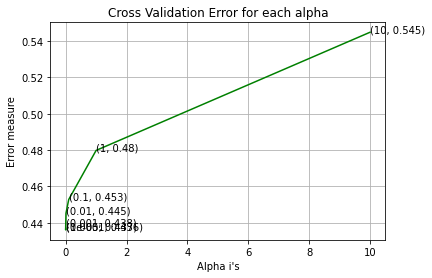

For values of best alpha =  0.0001 The train log loss is: 0.43112437564276057
For values of best alpha =  0.0001 The test log loss is: 0.43609896840356943
Total number of data points : 121287


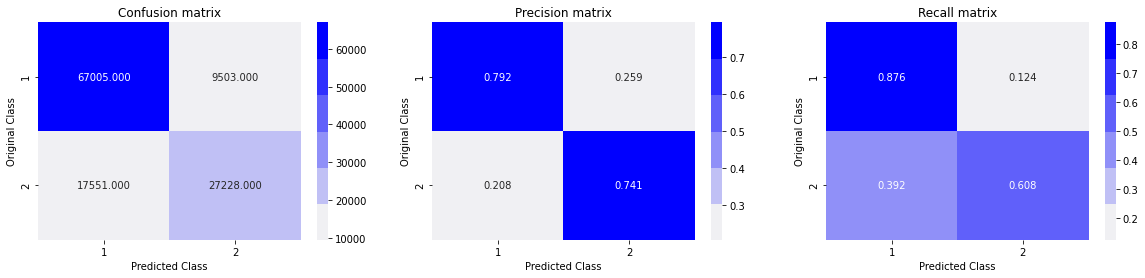

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] 

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)


Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.4628855123478549
For values of alpha =  0.0001 The log loss is: 0.4516122992395898
For values of alpha =  0.001 The log loss is: 0.45282188417691144
For values of alpha =  0.01 The log loss is: 0.5086797649551945
For values of alpha =  0.1 The log loss is: 0.49873255427189855
For values of alpha =  1 The log loss is: 0.5801712556173496
For values of alpha =  10 The log loss is: 0.645270675663122


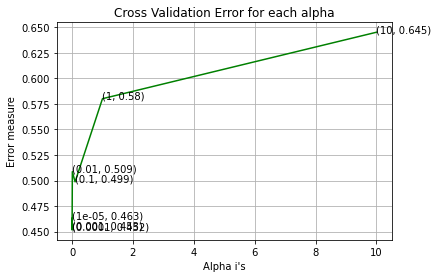

For values of best alpha =  0.0001 The train log loss is: 0.44786395313599536
For values of best alpha =  0.0001 The test log loss is: 0.4516122992395898
Total number of data points : 121287


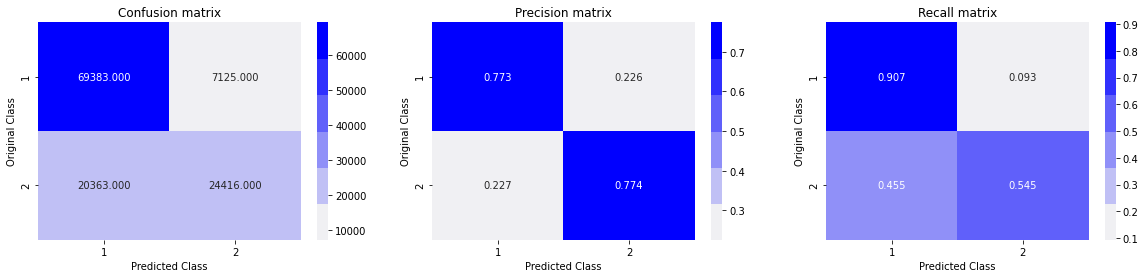

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] 

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)